In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics, pipeline
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance

In [2]:
file_path = '../Data/RAW_activePlayerCareerLogData.pickle'
PLAYER = 'kyrie irving'

### Process data

In [229]:
# Load collected player data from pickle file
with open(file_path, 'rb') as file:
    activePlayerCareerLog = pickle.load(file)

In [230]:
df_player = activePlayerCareerLog[PLAYER].dropna()
df_player.head()

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,HOME,OPP,TEAM
0,22016,202681,2016-10-25,W,30,12,22,4,7,1,...,4,2,0,0,1,29,13,1,NYK,CLE
1,22016,202681,2016-10-28,W,38,10,23,5,9,1,...,6,0,0,7,4,26,8,0,TOR,CLE
2,22016,202681,2016-10-29,W,37,7,18,2,6,4,...,2,0,2,1,2,20,7,1,ORL,CLE
3,22016,202681,2016-11-01,W,35,10,19,4,6,8,...,4,0,0,3,1,32,-2,1,HOU,CLE
4,22016,202681,2016-11-03,W,34,9,18,3,8,2,...,6,0,0,3,3,23,2,1,BOS,CLE


In [233]:
# Remove any empty values from player careers
emptyKeys = [k for k, v in activePlayerCareerLog.items() if not isinstance(v, pd.DataFrame)]
for k in emptyKeys:
    del activePlayerCareerLog[k]

In [232]:
# Clean Data and add features

for name, df_player in activePlayerCareerLog.items():
    #df_player['SEASON_ID'] = df_player['SEASON_ID'].apply(lambda x: x[1:])
    df_player['WL'].replace({'L': 0, 'W': 1}, inplace=True)
    
    df_player['REST'] = 0
    for idx in df_player.index[1:]:
        date_difference = df_player['GAME_DATE'].iloc[idx] - df_player['GAME_DATE'].iloc[idx - 1]
        df_player.at[idx, 'REST'] = date_difference.days

    df_player.at[0, 'REST'] = 4 # assumed rest from NBA preseason to season start

In [180]:
activePlayerCareerLog[PLAYER].head()

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,HOME,OPP,TEAM,REST
0,22016,202681,2016-10-25,1,30,12,22,4,7,1,...,2,0,0,1,29,13,1,NYK,CLE,4
1,22016,202681,2016-10-28,1,38,10,23,5,9,1,...,0,0,7,4,26,8,0,TOR,CLE,3
2,22016,202681,2016-10-29,1,37,7,18,2,6,4,...,0,2,1,2,20,7,1,ORL,CLE,1
3,22016,202681,2016-11-01,1,35,10,19,4,6,8,...,0,0,3,1,32,-2,1,HOU,CLE,3
4,22016,202681,2016-11-03,1,34,9,18,3,8,2,...,0,0,3,3,23,2,1,BOS,CLE,2


<AxesSubplot: xlabel='GAME_DATE'>

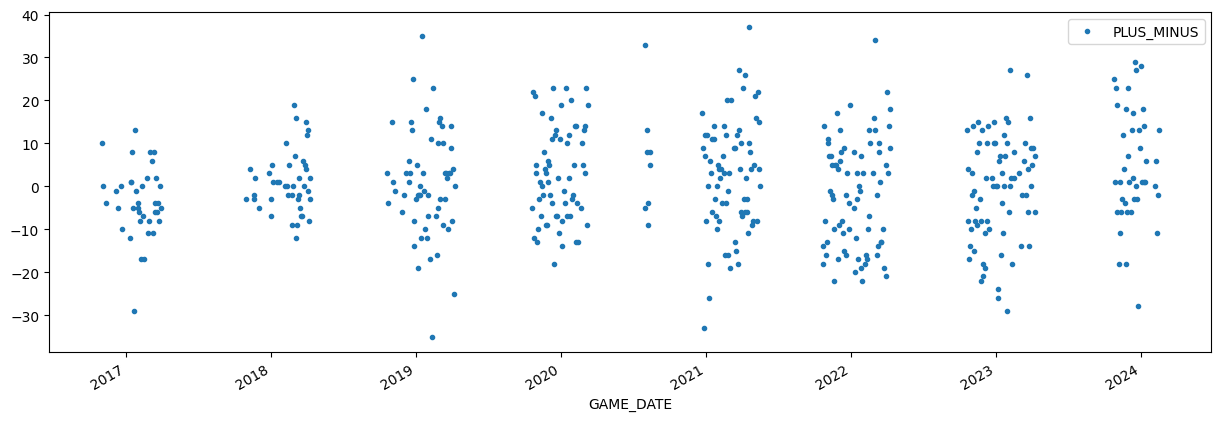

In [12]:
df_player.plot(x='GAME_DATE', y='PLUS_MINUS', style='.', figsize=(15,5))

<AxesSubplot: xlabel='REST'>

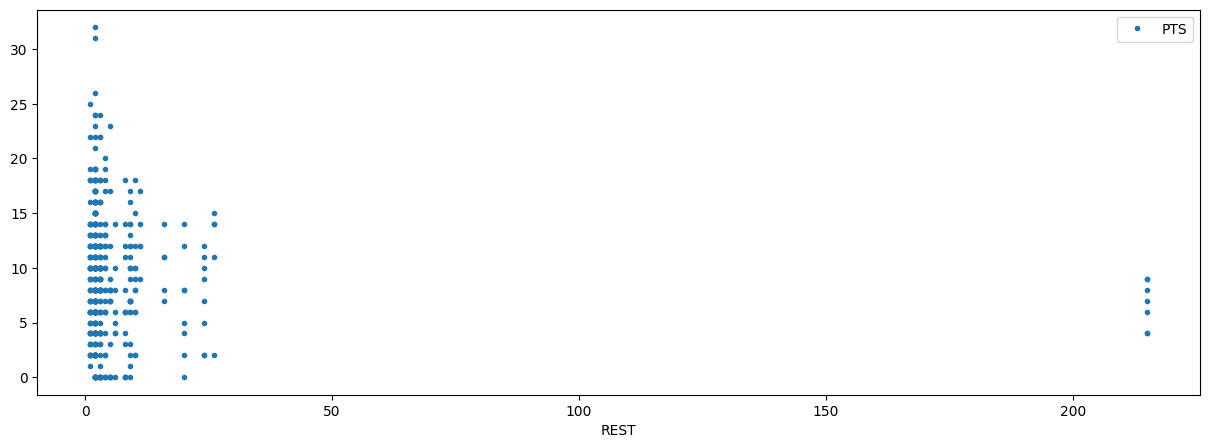

In [13]:
df_player.plot(x='REST', y='PTS', style='.', figsize=(15,5))

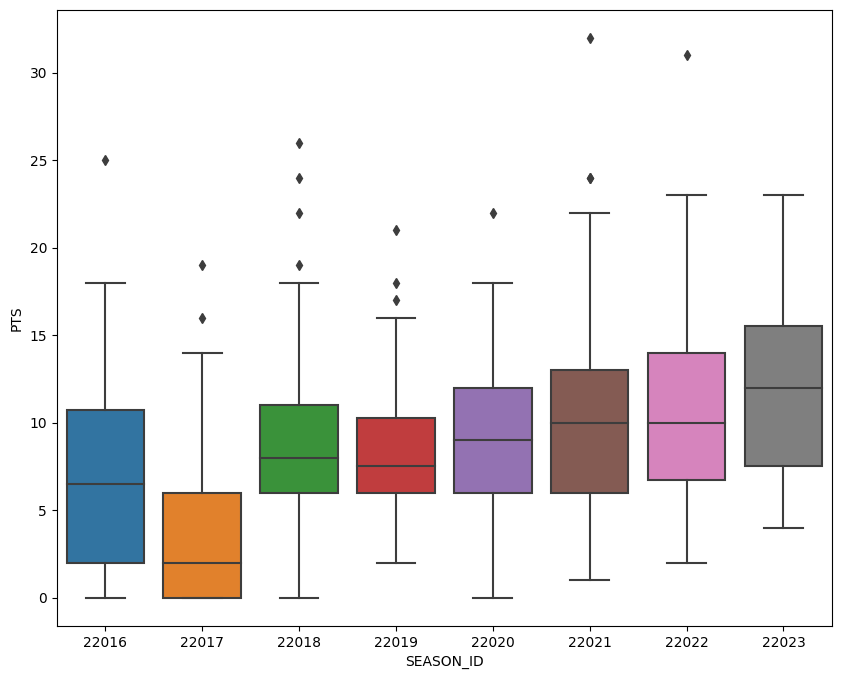

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data= df_player, x='SEASON_ID', y='PTS')
plt.show()

In [234]:
# Save cleaned player data into a pickle file
file_path = '../Data/activePlayerCareerLogData.pickle'
with open(file_path, 'wb') as f:
    pickle.dump(activePlayerCareerLog, f)

### Time Series Feature Engineering

In [3]:
# Load collected player data from pickle file
with open('../Data/activePlayerCareerLogData.pickle', 'rb') as file:
    activePlayerCareerLog = pickle.load(file)

In [4]:
target = 'PTS'
cols_to_drop = ['SEASON_ID', 'Player_ID', 'GAME_DATE', 'OPP', 'TEAM', target + '_target']

In [5]:
# one lag time step
def shift_target(df):
    df[target + '_target'] = df[target].shift(-1)
    df.dropna(inplace=True)
    return df

In [6]:
# rolling window
def recent_average(df, target, games=5):
    shifted_stat = df[target]
    window = shifted_stat.rolling(window=games).mean()
    df['LAST_' + str(games) + '_' + target] = window
    return df

def recent_percentage(df, target1, target2, games=5):
    shifted_stat1 = df[target1]
    shifted_stat2 = df[target2]
    stat_percentage = shifted_stat1 / shifted_stat2
    window = stat_percentage.rolling(window=games).mean()
    df['LAST_' + str(games) + '_' + target1 + '_PCT'] = window
    return df

In [7]:
df_player = activePlayerCareerLog[PLAYER].copy()
df_player = shift_target(df_player)
df_player = recent_average(df_player, target, 3)
df_player = recent_average(df_player, target, 5)
df_player = recent_average(df_player, target, 7)
df_player = recent_average(df_player, 'PLUS_MINUS', 3)
df_player = recent_percentage(df_player, 'FGM', 'FGA', 3)

In [10]:
df_player.head(5)

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,OPP,TEAM,REST,PTS_target,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT,LAST_3_FGM_PCT
6,22016,202681,2016-11-08,0,39,11,27,1,7,6,...,ATL,CLE,3,29.0,NaN,NaN,NaN,NaN,0.399817,NaN
7,22016,202681,2016-11-11,1,36,11,23,4,9,3,...,WAS,CLE,3,19.0,NaN,NaN,NaN,NaN,0.417691,NaN
8,22016,202681,2016-11-13,1,27,8,17,1,5,2,...,CHA,CLE,2,24.0,25.666667,NaN,NaN,2.666667,0.406545,0.452086
9,22016,202681,2016-11-15,1,35,10,20,2,4,2,...,TOR,CLE,2,24.0,24.000000,NaN,NaN,4.666667,0.406545,0.482950
10,22016,202681,2016-11-16,0,32,10,20,1,5,3,...,IND,CLE,1,25.0,22.333333,25.0,NaN,-2.666667,0.471251,0.490196


In [11]:
for player in activePlayerCareerLog.values():
    player = shift_target(player)
    player = recent_average(player, target, 3)
    player = recent_average(player, target, 5)
    player = recent_average(player, target, 7)
    player = recent_average(player, 'PLUS_MINUS', 3)
    player = recent_percentage(player, 'FGM', 'FGA', 5)

In [12]:
activePlayerCareerLog['aaron gordon'].head()

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,HOME,OPP,TEAM,REST,PTS_target,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
6,22016,203932,2016-11-07,0,30,6,15,1,4,2,...,0,CHI,ORL,2,7.0,NaN,NaN,NaN,NaN,NaN
7,22016,203932,2016-11-09,0,31,2,9,0,3,3,...,1,MIN,ORL,2,9.0,NaN,NaN,NaN,NaN,NaN
8,22016,203932,2016-11-11,0,25,4,9,0,1,1,...,1,UTA,ORL,2,12.0,10.333333,NaN,NaN,-6.666667,NaN
9,22016,203932,2016-11-13,1,22,5,9,1,3,1,...,0,OKC,ORL,2,11.0,9.333333,NaN,NaN,-4.333333,NaN
10,22016,203932,2016-11-14,0,22,5,11,1,4,0,...,0,IND,ORL,1,10.0,10.666667,10.8,NaN,-0.666667,0.415354


### Train / Test Split

In [13]:
df_columns = list(activePlayerCareerLog[PLAYER].columns)
features = df_columns
for col in cols_to_drop:
    features.remove(col)
print(features)

['WL', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'HOME', 'REST', 'LAST_3_PTS', 'LAST_5_PTS', 'LAST_7_PTS', 'LAST_3_PLUS_MINUS', 'LAST_5_FGM_PCT']


In [14]:
# Split players into train and test sets
split_ratio = 0.7
players_train = list(activePlayerCareerLog.keys())[:int(split_ratio * len(activePlayerCareerLog))]
players_test = list(activePlayerCareerLog.keys())[int(split_ratio * len(activePlayerCareerLog)):]
print(len(players_train), len(players_test))

309 133


In [15]:
train = df_player.loc[df_player['SEASON_ID'] < '2022']
test = df_player.loc[df_player['SEASON_ID'] >= '2022']

In [16]:
X_train = pd.concat(activePlayerCareerLog[key][features] for key in players_train)
X_test = pd.concat(activePlayerCareerLog[key][features] for key in players_test)

y_train = pd.concat(activePlayerCareerLog[key][[target + '_target']] for key in players_train)
y_test = pd.concat(activePlayerCareerLog[key][[target + '_target']] for key in players_test)

### Data Normalization and Standardization

In [17]:
norm_scaler = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')

X_train_norm = norm_scaler.fit_transform(X_train)
X_test_norm = norm_scaler.fit_transform(X_test)
y_train_norm = norm_scaler.fit_transform(y_train)
y_test_norm = norm_scaler.fit_transform(y_test)

In [18]:
X_train_norm.head()

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
6,0.0,0.241379,0.08,0.100,0.0,0.0,0.076923,0.06250,0.230769,0.090909,...,0.166667,0.082192,0.583333,1.0,0.001005,NaN,NaN,NaN,NaN,NaN
7,1.0,0.224138,0.12,0.075,0.0,0.0,0.038462,0.03125,0.000000,0.090909,...,0.666667,0.095890,0.564815,0.0,0.002010,NaN,NaN,NaN,NaN,NaN
8,0.0,0.620690,0.28,0.225,0.0,0.0,0.115385,0.12500,0.461538,0.318182,...,0.666667,0.232877,0.462963,0.0,0.002010,0.184049,NaN,NaN,0.540670,NaN
9,0.0,0.465517,0.16,0.125,0.0,0.0,0.076923,0.18750,0.384615,0.272727,...,0.166667,0.136986,0.351852,0.0,0.001005,0.208589,NaN,NaN,0.421053,NaN
10,0.0,0.189655,0.04,0.050,0.0,0.0,0.115385,0.12500,0.076923,0.136364,...,0.166667,0.068493,0.462963,1.0,0.001005,0.196319,0.172414,NaN,0.368421,0.57


In [19]:
std_scaler = StandardScaler().set_output(transform="pandas")

X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.fit_transform(X_test)
y_train_std = std_scaler.fit_transform(y_train)
y_test_std = std_scaler.fit_transform(y_test)

In [20]:
print(X_train_std.shape)
X_train_std.head()

(76695, 25)


,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
6,-1.028397,-1.464911,-0.866566,-0.899675,-0.914195,-1.261631,-0.064526,-0.237612,1.381984,-0.628866,...,-0.740737,-0.813200,0.527350,0.995174,-0.114540,NaN,NaN,NaN,NaN,NaN
7,0.972387,-1.577901,-0.564285,-1.067374,-0.914195,-1.261631,-0.437936,-0.551499,-0.757424,-0.628866,...,1.333762,-0.702561,0.363460,-1.004849,-0.060049,NaN,NaN,NaN,NaN,NaN
8,-1.028397,1.020863,0.644838,-0.061182,-0.914195,-1.261631,0.308884,0.390162,3.521393,1.128692,...,1.333762,0.403826,-0.537933,-1.004849,-0.060049,-0.446665,NaN,NaN,0.190684,NaN
9,-1.028397,0.003956,-0.262004,-0.731977,-0.914195,-1.261631,-0.064526,1.017936,2.808257,0.777180,...,-0.740737,-0.370645,-1.521272,-1.004849,-0.114540,-0.270455,NaN,NaN,-0.922924,NaN
10,-1.028397,-1.803880,-1.168847,-1.235073,-0.914195,-1.261631,0.308884,0.390162,-0.044288,-0.277355,...,-0.740737,-0.923839,-0.537933,0.995174,-0.114540,-0.358560,-0.611891,NaN,-1.412912,0.970987


In [21]:
print("Train Shape: X = {} , y = {}".format(X_train.shape, y_train.shape))
print("Test Shape: X = {} , y = {}".format(X_test.shape, y_test.shape))

Train Shape: X = (76695, 25) , y = (76695, 1)
Test Shape: X = (30042, 25) , y = (30042, 1)


In [22]:
X_train.describe()

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
count,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,...,76695.000000,76695.000000,76695.000000,76695.000000,76695.000000,76093.000000,75494.000000,74898.000000,76093.000000,75494.000000
mean,0.513997,26.964991,4.866758,10.364835,1.443732,3.944625,2.172801,2.756999,1.062103,3.789034,...,2.071204,13.350049,0.564574,0.502419,4.102014,13.379790,13.408432,13.437240,0.573075,0.463514
std,0.499807,8.850419,3.308204,5.963118,1.579249,3.126629,2.678038,3.185882,1.402266,2.844875,...,1.446142,9.038487,12.203405,0.499997,18.351971,7.566777,7.204654,7.028397,7.483232,0.109668
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-56.000000,0.000000,1.000000,0.000000,0.000000,0.714286,-35.666667,0.000000
25%,0.000000,21.000000,2.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,6.000000,-8.000000,0.000000,2.000000,7.666667,8.000000,8.000000,-4.333333,0.395344
50%,1.000000,28.000000,4.000000,9.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,...,2.000000,12.000000,0.000000,1.000000,2.000000,12.000000,12.000000,12.000000,0.333333,0.458905
75%,1.000000,34.000000,7.000000,14.000000,2.000000,6.000000,3.000000,4.000000,2.000000,5.000000,...,3.000000,19.000000,9.000000,1.000000,3.000000,18.000000,17.800000,17.571429,5.333333,0.524762
max,1.000000,58.000000,25.000000,41.000000,13.000000,23.000000,26.000000,32.000000,13.000000,22.000000,...,6.000000,73.000000,52.000000,1.000000,996.000000,54.333333,52.200000,48.857143,34.000000,1.000000


### Training - XGBoost 

In [23]:
param_grid = {
    #'learning_rate' : [0.1, 0.05],
    'max_depth' : [4, 5, 6],
    #'min_child_weight' : [4, 16],
    #'n_estimators' : [7, 8, 9],
    #'gamma' : [i / 10.0 for i in range(0,5)],
    #'reg_alpha' : [0.01, 0.03, 0.05, 0.07, 0.1]
}

In [24]:
params = {
    'learning_rate' : 0.07,
    'max_depth' : 5,
    'n_estimators' : 90,
    'gamma' : 0,
    'min_child_weight' : 16,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'reg_alpha' : 0.07
}

In [25]:
model = xgb.XGBRegressor(**params)

xgtrain = xgb.DMatrix(X_train, y_train)
cvresult = xgb.cv(params, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5, metrics='rmse', early_stopping_rounds=50)

cvresult

c:\Users\micha\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:160: UserWarning: [19:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\micha\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:160: UserWarning: [19:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.811229,0.008454,8.813043,0.032844
1,8.565645,0.007966,8.568875,0.031692
2,8.323225,0.008103,8.328262,0.029924
3,8.111041,0.007341,8.118196,0.029113
4,7.917575,0.007216,7.926327,0.027898
...,...,...,...,...
85,6.365451,0.006714,6.501808,0.023532
86,6.364290,0.006969,6.501982,0.023550
87,6.363029,0.007119,6.501894,0.023580
88,6.361711,0.007065,6.501760,0.023400


In [26]:
model = xgb.XGBRegressor(**params)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train_std, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.07, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=16, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=90,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [4, 5, 6]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [27]:
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'max_depth': 5}


In [28]:
best_model = xgb.XGBRegressor(**params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=16, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred = best_model.predict(X_test).round()
y_pred = y_pred.reshape(-1, 1)
y_pred.astype(int)

y_test = np.array(y_test).astype(int)

metrics.accuracy_score(y_test, y_pred)

0.06314493043073031

In [30]:
best_model_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
best_model_results['Error'] = abs(best_model_results['Actual'] - best_model_results['Predicted'])
best_model_results.describe()

,Actual,Predicted,Error
count,30042.000000,30042.000000,30042.000000
mean,12.794321,12.893716,4.994341
std,8.522477,5.832686,4.051272
min,0.000000,3.000000,0.000000
25%,6.000000,8.000000,2.000000
50%,12.000000,12.000000,4.000000
75%,18.000000,17.000000,7.000000
max,62.000000,39.000000,42.000000


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

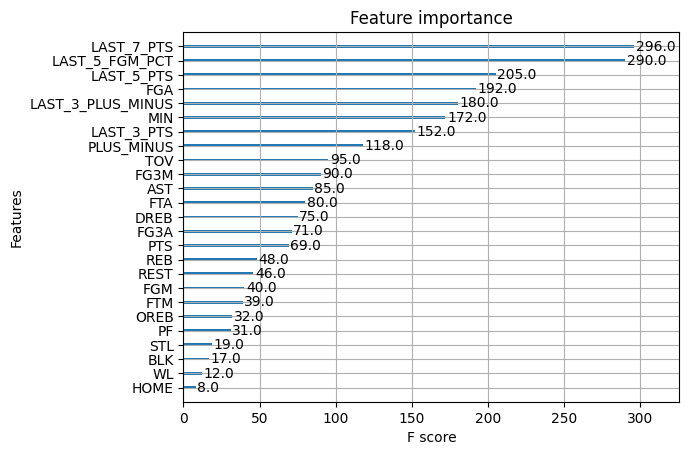

In [31]:
plot_importance(best_model)

<AxesSubplot: title={'center': 'Feature Importance'}>

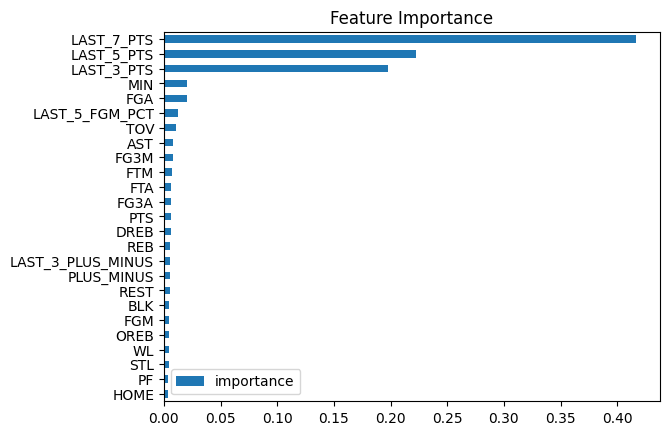

In [32]:
fi = pd.DataFrame(data= best_model.feature_importances_,
                index= best_model.feature_names_in_,
                columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [49]:
# save best model
file_name = "../Data/xgb_points.pickle" 
pickle.dump(best_model, open(file_name, "wb"))

### Training - XGBoost (standardized)

In [33]:
print(X_train_std.shape)
print(y_train.shape)

(76695, 25)
(76695, 1)


In [34]:
reg_std = xgb.XGBRegressor(**best_params)
reg_std.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

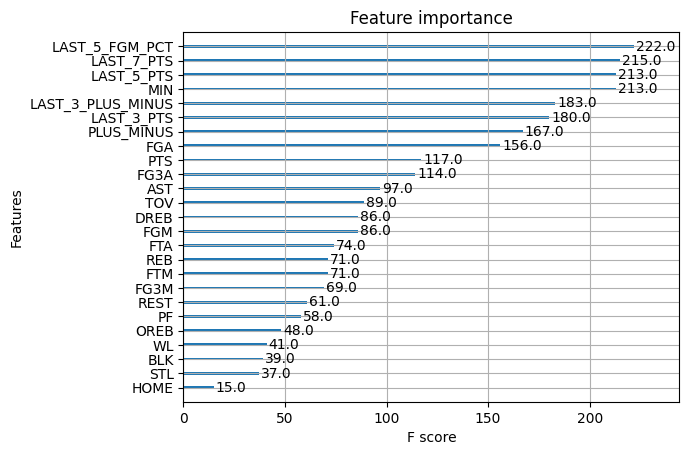

In [35]:
plot_importance(reg_std)

In [36]:
y_pred_std = reg_std.predict(X_test_std).round()
y_pred_std = y_pred_std.reshape(-1, 1)
y_pred_std.astype(int)

metrics.accuracy_score(y_test, y_pred_std)

0.06351108448172559

In [37]:
std_model_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_std.flatten()})
std_model_results['Error'] = abs(std_model_results['Actual'] - std_model_results['Predicted'])
std_model_results.describe()

,Actual,Predicted,Error
count,30042.000000,30042.000000,30042.000000
mean,12.794321,13.149524,5.059417
std,8.522477,6.347830,4.136888
min,0.000000,2.000000,0.000000
25%,6.000000,8.000000,2.000000
50%,12.000000,12.000000,4.000000
75%,18.000000,17.000000,7.000000
max,62.000000,47.000000,43.000000


### Training - XGBoost (normalized)

In [38]:
reg_norm = xgb.XGBRegressor(**best_params)
reg_norm.fit(X_train_norm, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

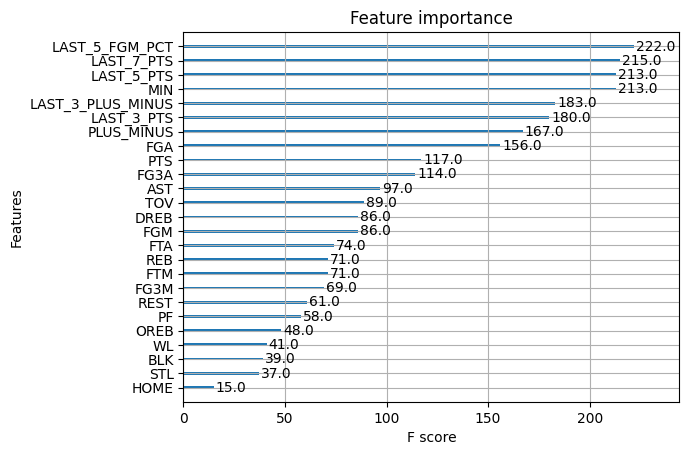

In [39]:
plot_importance(reg_norm)

In [40]:
y_pred_norm = reg_norm.predict(X_test_norm).round()
y_pred_norm = y_pred_norm.reshape(-1, 1)
y_pred_norm.astype(int)

metrics.accuracy_score(y_test, y_pred_norm)

0.05535583516410359

In [41]:
norm_model_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_norm.flatten()})
norm_model_results['Error'] = abs(norm_model_results['Actual'] - norm_model_results['Predicted'])
norm_model_results.describe()

,Actual,Predicted,Error
count,30042.000000,30042.000000,30042.000000
mean,12.794321,14.881832,5.489415
std,8.522477,7.119322,4.366911
min,0.000000,1.000000,0.000000
25%,6.000000,9.000000,2.000000
50%,12.000000,13.000000,5.000000
75%,18.000000,20.000000,8.000000
max,62.000000,54.000000,41.000000


### Individual Player Model

In [42]:
df_player = activePlayerCareerLog[PLAYER]
df_player.head(7)

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,HOME,OPP,TEAM,REST,PTS_target,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
6,22016,202681,2016-11-08,0,39,11,27,1,7,6,...,1,ATL,CLE,3,29.0,NaN,NaN,NaN,NaN,NaN
7,22016,202681,2016-11-11,1,36,11,23,4,9,3,...,0,WAS,CLE,3,19.0,NaN,NaN,NaN,NaN,NaN
8,22016,202681,2016-11-13,1,27,8,17,1,5,2,...,1,CHA,CLE,2,24.0,25.666667,NaN,NaN,2.666667,NaN
9,22016,202681,2016-11-15,1,35,10,20,2,4,2,...,1,TOR,CLE,2,24.0,24.000000,NaN,NaN,4.666667,NaN
10,22016,202681,2016-11-16,0,32,10,20,1,5,3,...,0,IND,CLE,1,25.0,22.333333,25.0,NaN,-2.666667,0.471251
11,22016,202681,2016-11-18,1,29,11,15,3,4,0,...,1,DET,CLE,2,20.0,24.333333,24.2,NaN,7.000000,0.536436
12,22016,202681,2016-11-23,1,33,8,15,3,6,1,...,1,POR,CLE,5,25.0,23.000000,22.4,24.285714,14.000000,0.547451


In [43]:
df_train = df_player[df_player['GAME_DATE'] < pd.Timestamp('2023-10-01')]
df_test = df_player[df_player['GAME_DATE'] > pd.Timestamp('2022-10-01')]
print(df_train.shape)
print(df_test.shape)

(356, 31)
(91, 31)


In [44]:
X_train_p = df_train[features]
y_train_p = df_train[target + '_target']

X_test_p = df_test[features]
y_test_p = df_test[target + '_target']

In [45]:
X_train_p.head()

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
6,0,39,11,27,1,7,6,7,0,1,...,3,29,-4,1,3,NaN,NaN,NaN,NaN,NaN
7,1,36,11,23,4,9,3,4,0,2,...,3,29,17,0,3,NaN,NaN,NaN,NaN,NaN
8,1,27,8,17,1,5,2,2,2,1,...,2,19,-5,1,2,25.666667,NaN,NaN,2.666667,NaN
9,1,35,10,20,2,4,2,4,2,3,...,3,24,2,1,2,24.000000,NaN,NaN,4.666667,NaN
10,0,32,10,20,1,5,3,4,1,1,...,3,24,-5,0,1,22.333333,25.0,NaN,-2.666667,0.471251


In [46]:
norm_scaler.fit_transform(X_train_p).head()

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
6,0.0,0.804348,0.55,0.81250,0.111111,0.4375,0.352941,0.411765,0.0,0.1,...,0.6,0.483333,0.391304,1.0,0.285714,NaN,NaN,NaN,NaN,NaN
7,1.0,0.739130,0.55,0.68750,0.444444,0.5625,0.176471,0.235294,0.0,0.2,...,0.6,0.483333,0.695652,0.0,0.285714,NaN,NaN,NaN,NaN,NaN
8,1.0,0.543478,0.40,0.50000,0.111111,0.3125,0.117647,0.117647,0.4,0.1,...,0.4,0.316667,0.376812,1.0,0.142857,0.432990,NaN,NaN,0.472603,NaN
9,1.0,0.717391,0.50,0.59375,0.222222,0.2500,0.117647,0.235294,0.4,0.3,...,0.6,0.400000,0.478261,1.0,0.142857,0.381443,NaN,NaN,0.513699,NaN
10,0.0,0.652174,0.50,0.59375,0.111111,0.3125,0.176471,0.235294,0.2,0.1,...,0.6,0.400000,0.376812,0.0,0.000000,0.329897,0.429752,NaN,0.363014,0.46298


In [47]:
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:
def modelfit(alg, X_train, y_train, cv_folds=5, early_stopping_rounds=50):
    

In [778]:
param_grid = {
    #'learning_rate' : [0.1, 0.01],
    #'max_depth' : [7, 8, 9],
    #'n_estimators' : [7, 8, 9],
    #'gamma' : [i / 10.0 for i in range(0,5)],
    #'min_child_weight' : [1, 2, 3]
    'reg_alpha' : [1, 0.1, 0.05, 0.01, 0.005, 0.001]
}

In [794]:
params = {
    'learning_rate' : 0.01,
    'max_depth' : 8,
    'n_estimators' : 9,
    'gamma' : 0.4,
    'min_child_weight' : 2
}

In [800]:
model = xgb.XGBRegressor(**params)

xgtrain = xgb.DMatrix(X_train_p, y_train_p)
cvresult = xgb.cv(params, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5, metrics='rmse', early_stopping_rounds=50)

cvresult

c:\Users\micha\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.744190,0.121839,8.783340,0.485175
1,8.704535,0.122243,8.787647,0.488197
2,8.665362,0.122658,8.791448,0.491006
3,8.626707,0.122471,8.796102,0.494295
4,8.589563,0.122817,8.801243,0.497883
5,8.552344,0.124843,8.806885,0.498776
6,8.515440,0.124820,8.811364,0.501778
7,8.478112,0.124434,8.817461,0.504460
8,8.442678,0.127338,8.822435,0.505615


In [795]:
p_model = xgb.XGBRegressor(**params)

p_grid_search = GridSearchCV(p_model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
p_grid_search.fit(std_scaler.fit_transform(X_train_p), y_train_p)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.4,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, ma...ne,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=8, max_leaves=None,
                                    min_child_weight=2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=9,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'reg_alpha': [1, 0.1, 0.05, 0.01, 0.005, 0.001]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [791]:
p_grid_search.best_index_

3

In [792]:
p_grid_search.best_score_

-8.775826176833416

In [796]:
p_best_params = p_grid_search.best_params_
print("Best Hyperparameters: ", p_best_params)

Best Hyperparameters:  {'reg_alpha': 0.01}


In [797]:
best_model_player = xgb.XGBRegressor(**params)
best_model_player.fit(std_scaler.fit_transform(X_train_p), y_train_p)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=9, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [798]:
best_model_player.feature_names_in_

array(['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'WL',
       'HOME', 'REST', 'LAST_5_PTS'], dtype='<U10')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

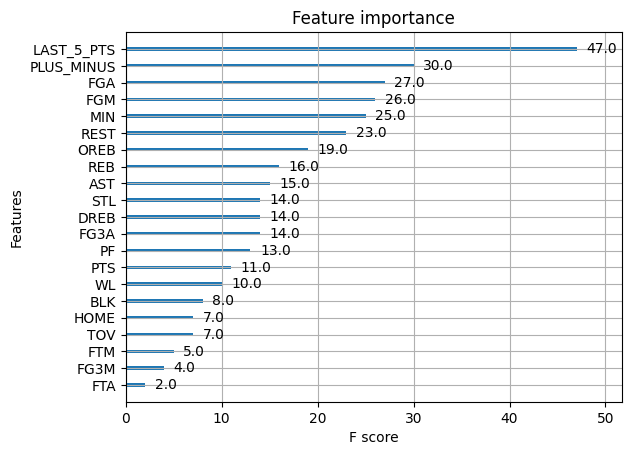

In [799]:
plot_importance(best_model_player)

<AxesSubplot: title={'center': 'Feature Importance'}>

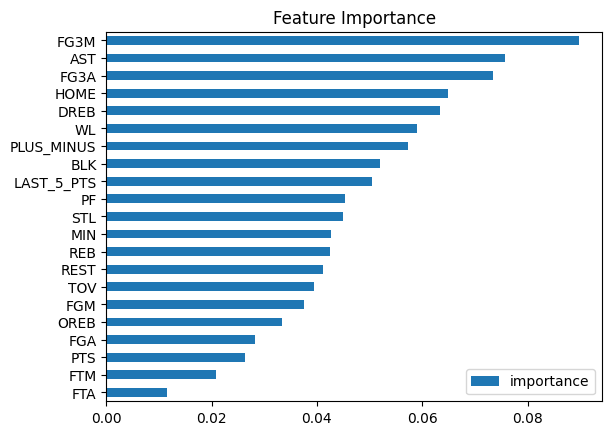

In [788]:
fi = pd.DataFrame(data= best_model_player.feature_importances_,
                index= best_model_player.feature_names_in_,
                columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [789]:
p_y_pred = best_model_player.predict(std_scaler.fit_transform(X_test_p)).round()
p_y_pred = p_y_pred.reshape(-1, 1)
p_y_pred.astype(int)

p_y_test = np.array(y_test_p).astype(int)
print(p_y_pred)
metrics.accuracy_score(p_y_test, p_y_pred)

[[26.]
 [25.]
 [26.]
 [26.]
 [27.]
 [26.]
 [26.]
 [26.]
 [26.]
 [25.]
 [25.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [27.]
 [25.]
 [26.]
 [25.]
 [25.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [25.]
 [25.]
 [27.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [26.]
 [26.]
 [25.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [27.]
 [26.]
 [26.]
 [25.]
 [25.]
 [25.]
 [26.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [26.]
 [25.]
 [25.]
 [27.]
 [26.]
 [26.]
 [26.]
 [27.]
 [25.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [26.]
 [25.]
 [26.]
 [26.]
 [26.]]


0.03260869565217391

In [606]:
print(p_y_pred.shape)
print(y_test_p.shape)

(92, 1)
(92,)
